## Импорт необходимых библиотек

In [72]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import importlib
from utils import functions
from models import deeplabv3
importlib.reload(functions)

<module 'utils.functions' from 'C:\\Users\\Raindow\\Desktop\\СПБГУ\\utils\\functions.py'>

## Конфигурация PyTorch

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [74]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256

## Класс, описывающий датасет

In [75]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [76]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])


## Загрузка датасета

In [77]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [78]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [79]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Обучение модели DeepLabV3+

In [80]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3.DeepLabV3PlusResNet50(num_classes=1).to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "deeplabv3+.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")


Epoch 1/100
Train Loss: 0.4854 | Test Loss: 0.4792
IoU: 0.7722 | Dice: 0.7722
------------------------
Best model saved at epoch 1 with IoU: 0.7722
Epoch 2/100
Train Loss: 0.4549 | Test Loss: 0.5985
IoU: 0.7696 | Dice: 0.7696
------------------------
Epoch 3/100
Train Loss: 0.4525 | Test Loss: 0.4225
IoU: 0.7722 | Dice: 0.7722
------------------------
Epoch 4/100
Train Loss: 0.4531 | Test Loss: 0.4719
IoU: 0.7688 | Dice: 0.7688
------------------------
Epoch 5/100
Train Loss: 0.4502 | Test Loss: 0.4227
IoU: 0.7485 | Dice: 0.7505
------------------------
Epoch 6/100
Train Loss: 0.4417 | Test Loss: 0.4292
IoU: 0.7426 | Dice: 0.7539
------------------------
Epoch 7/100
Train Loss: 0.4416 | Test Loss: 0.4406
IoU: 0.7360 | Dice: 0.7467
------------------------
Epoch 8/100
Train Loss: 0.4383 | Test Loss: 0.4933
IoU: 0.7713 | Dice: 0.7713
------------------------
Epoch 9/100
Train Loss: 0.4390 | Test Loss: 0.4306
IoU: 0.7467 | Dice: 0.7579
------------------------
Epoch 10/100
Train Loss: 0.4

## Метрики

## Train/test losses

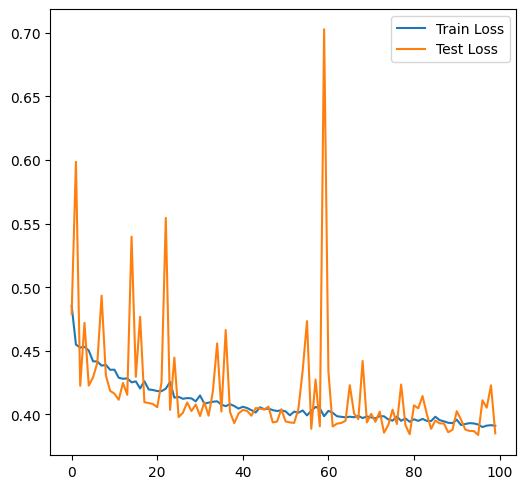

In [83]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

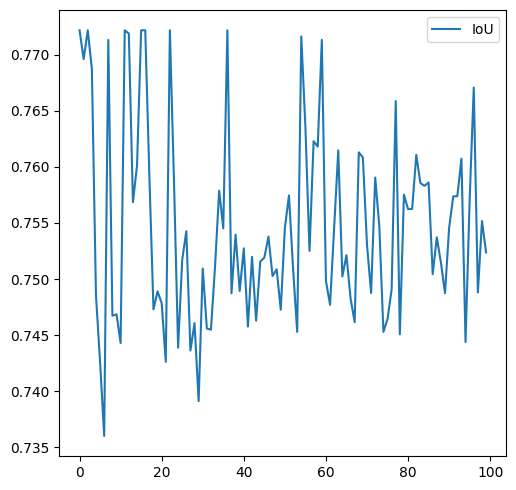

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

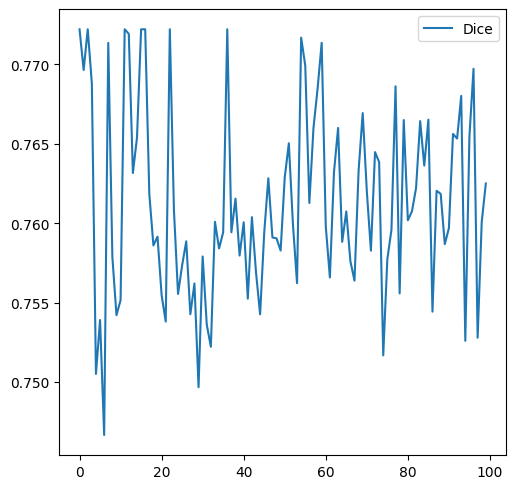

In [88]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

## Примеры результатов сегментации

В качестве примеров были выбраны изображения с "неоднозначным" расположением следов от дренажных труб для демонстрации способности модели выделять целевой класс в условиях низкой контрастности между пикселями фона и дренажных труб.

In [195]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from transformers import SegformerForSemanticSegmentation
from models import deeplabv3

# Пути к изображениям
image_path_1 = "image_4215.png"
image_path_2 = "image_28.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Функция по загрузке и преобразованию изображения
def preprocess_image(image_path, img_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")  # RGB формат
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0) 
    return image

In [56]:
image = preprocess_image(image_path_1).to(device)

deeplab_model = deeplabv3.DeepLabV3PlusResNet50(num_classes=1).to(device)
deeplab_model.load_state_dict(torch.load("deeplabv3_test.pth"))
deeplab_model.eval()

deeplab_model_outputs = deeplab_model(image)
with torch.no_grad():
     pred_mask = torch.sigmoid(deeplab_model_outputs).squeeze().cpu().numpy()
     pred_mask = (pred_mask > 0.55).astype(np.uint8)

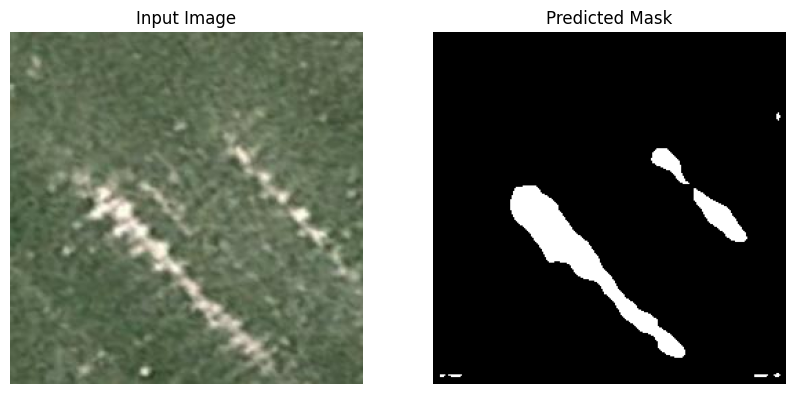

In [57]:
# Отображение исходного изображения и маски
plt.figure(figsize=(10, 5))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path_1))
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [208]:
image = preprocess_image(image_path_2).to(device)

deeplab_model = deeplabv3.DeepLabV3PlusResNet50(num_classes=1).to(device)
deeplab_model.load_state_dict(torch.load("deeplabv3_test.pth"))
deeplab_model.eval()

deeplab_model_outputs = deeplab_model(image)
with torch.no_grad():
     pred_mask = torch.sigmoid(deeplab_model_outputs).squeeze().cpu().numpy()
     pred_mask = (pred_mask > 0.55).astype(np.uint8)

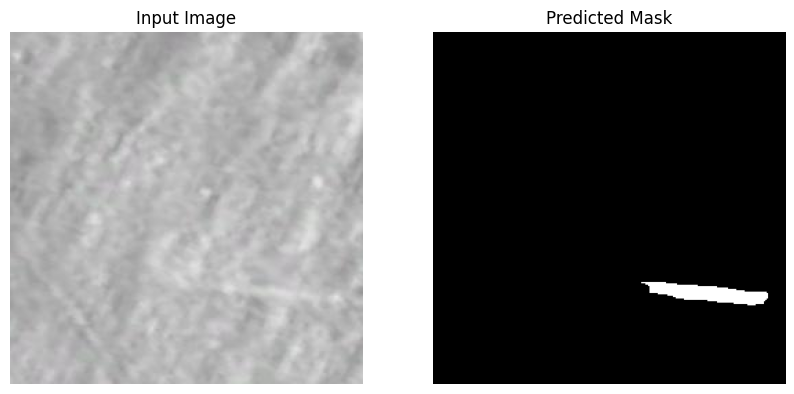

In [209]:
# Отображение исходного изображения и маски
plt.figure(figsize=(10, 5))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path_2))
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()